### Collecting data

In [1]:
import re

import string

def clean_and_tokenize(inp: str, only_clean: bool = False) -> list:

    # maps (replaces) each punctuation to " "
    inp = inp.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))

    # replaces multi-spaces with " "
    inp = re.sub(r'\s+', ' ', inp.lower())

    return inp if only_clean else inp.split()

text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''
tokens = clean_and_tokenize(text)
tokens

['machine',
 'learning',
 'is',
 'the',
 'study',
 'of',
 'computer',
 'algorithms',
 'that',
 'improve',
 'automatically',
 'through',
 'experience',
 'it',
 'is',
 'seen',
 'as',
 'a',
 'subset',
 'of',
 'artificial',
 'intelligence',
 'machine',
 'learning',
 'algorithms',
 'build',
 'a',
 'mathematical',
 'model',
 'based',
 'on',
 'sample',
 'data',
 'known',
 'as',
 'training',
 'data',
 'in',
 'order',
 'to',
 'make',
 'predictions',
 'or',
 'decisions',
 'without',
 'being',
 'explicitly',
 'programmed',
 'to',
 'do',
 'so',
 'machine',
 'learning',
 'algorithms',
 'are',
 'used',
 'in',
 'a',
 'wide',
 'variety',
 'of',
 'applications',
 'such',
 'as',
 'email',
 'filtering',
 'and',
 'computer',
 'vision',
 'where',
 'it',
 'is',
 'difficult',
 'or',
 'infeasible',
 'to',
 'develop',
 'conventional',
 'algorithms',
 'to',
 'perform',
 'the',
 'needed',
 'tasks']

In [2]:
def build_dict(tokens:list) -> tuple[dict,dict]:
    word2idx = {}
    idx2word = {}
    for i, t in enumerate(tokens):
        idx2word[i] = t
        word2idx[t] = i
    return word2idx, idx2word

w2i, i2w = build_dict(tokens)
w2i

{'machine': 51,
 'learning': 52,
 'is': 71,
 'the': 81,
 'study': 4,
 'of': 60,
 'computer': 67,
 'algorithms': 78,
 'that': 8,
 'improve': 9,
 'automatically': 10,
 'through': 11,
 'experience': 12,
 'it': 70,
 'seen': 15,
 'as': 63,
 'a': 57,
 'subset': 18,
 'artificial': 20,
 'intelligence': 21,
 'build': 25,
 'mathematical': 27,
 'model': 28,
 'based': 29,
 'on': 30,
 'sample': 31,
 'data': 36,
 'known': 33,
 'training': 35,
 'in': 56,
 'order': 38,
 'to': 79,
 'make': 40,
 'predictions': 41,
 'or': 73,
 'decisions': 43,
 'without': 44,
 'being': 45,
 'explicitly': 46,
 'programmed': 47,
 'do': 49,
 'so': 50,
 'are': 54,
 'used': 55,
 'wide': 58,
 'variety': 59,
 'applications': 61,
 'such': 62,
 'email': 64,
 'filtering': 65,
 'and': 66,
 'vision': 68,
 'where': 69,
 'difficult': 72,
 'infeasible': 74,
 'develop': 76,
 'conventional': 77,
 'perform': 80,
 'needed': 82,
 'tasks': 83}

### Creating a training set
Originally we have a set of tokens $\{t_1,t_2,t_3,...,t_N\}$. We convert this data into a trainable format i.e. $\{(t_2, t_1), (t_2, t_3), ...\}$, where the first element would be $x$ and the second - $y$. Hence our learning task will be related to predicting a neighbouring word inside some n-gram window based on the input token. This type of word2vec model is also refered as **skip-gram**.

In [7]:
import numpy as np


def ohe(token_idx: int, dict_size: int):
    # one-hot single vector encoding
    return [0 if i != token_idx else 1 for i in range(dict_size)]

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def generate_training_data(tokens: list, word2idx: dict, window: int):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue # skipping this step in a loop
            X.append(ohe(word2idx[tokens[i]], len(word2idx)))
            y.append(ohe(word2idx[tokens[j]], len(word2idx)))
    
    # asarray = array, but does not make a copy of it
    return np.asarray(X), np.asarray(y)
    
X, y = generate_training_data(tokens, w2i, 2)
X.shape, y.shape

((330, 60), (330, 60))

### Creating a model

#### Forward pass
Our model architecture would be the following:
$X_{N\times V}\rightarrow Z_1=\text{ReLU}(A_1=X\times W^1_{V\times E})\rightarrow Z_2=\sigma(A_2=Z_1\times W^2_{E\times V})$, where:
* $N$ - batch size
* $V$ - vocabulary size
* $E$ - embedding dimensions
* $\sigma$ - softmax activation

#### Backward pass
The most important thing I feel like is needed to be highlighted is that we're always looking at **one input row and NOT $N$**. 
##### Step 1: Calculating $\frac{\partial Z_2}{\partial A_2}$
Gradient varies if we're considering $i=j$ or $i\neq j$ cases, where $i$ and $j$ correspond to columns, i.e. different classes from $1$ to $C$:
* case $i=j$: 
    $$
        \frac{\partial}{\partial a^i_2}[\frac{exp(a^i_2)}{\sum^C_k exp(a^k_2)}]=\frac{exp(a^i_2)\sum^C_k exp(a^k_2)-exp^2(a^i_2)}{[\sum^C_k exp(a^k_2)]^2} = \\
        
        =\frac{exp(a^i_2)}{\sum^C_k exp(a^k_2)}(1-\frac{exp(a^i_2)}{\sum^C_k exp(a^k_2)})=z^i_2(1-z^i_2)
    $$
* case $i\neq j$:
    $$
        \frac{0-exp^2(a^j_2)exp^2(a^i_2)}{[\sum^C_k exp(a^k_2)]^2} = -z^i_2z^j_2
    $$

##### Step 2: Calculating $\frac{\partial L}{\partial A_2}$
For this problem we're going to use Cross Entropy loss: $L=-\sum_i^N y_i\log{p_i}$ (where $y$ and $p$ are vectors). This gradient is going to be shared across all updated parameters of the model, so it's the most crucial calculation of the whole backward pass:
$$
\frac{\partial L}{\partial A_2}=-\sum^C_k y_k\frac{\partial\log{z^k_2}}{\partial z^k_2}\times\frac{\partial z^k_2}{a^i_2}=\\

= y_i\frac{1}{z^i_2}\times z^i_2(1-z^i_2)+\sum^C_{k\neq i}y_k\frac{1}{z^k_2}z^i_2z^j_2=z^i_2y_i-y_i+\sum^C_{k\neq i}z^i_2y_k=\\

=z^i_2(\sum^C_{k\neq i}y_k + y_i)-y_i=z^i_2-y_i
$$
since $(\sum^C_{k\neq i}y_k + y_i)=1$, because $y$ is a onehot-encoded vector of probabilities that add up to $1$.

##### Step 3: Calculating $\frac{\partial L}{\partial W_2}$

1. First of all, $\frac{\partial A_2}{\partial W^j_2}=Z^i_1$, hence $\frac{\partial A_2}{\partial W_2}=Z^T_1$, which is of shape $E\times 1$
2. Our output shape of a gradient should be $E\times V$, therefore a proper matrix form of a chain rule would look like this: $\frac{\partial L}{\partial W_2}=\frac{\partial L}{\partial A_2}\frac{\partial A_2}{\partial W_2}=Z^T_1(Z_2-y)$

##### Step 4: Calculating $\frac{\partial L}{\partial W_1}$
Using a chain rule we write the gradient as $\frac{\partial L}{\partial A_2}\frac{\partial A_2}{\partial Z_1}\frac{\partial Z_1}{\partial A_1}\frac{\partial A_1}{\partial W_1}$
1. An arbitrary case of $\frac{\partial\text{ReLU}(x)}{\partial x}=I_{(0;\infty)}(x)$, where $I$ is an [indicator function](https://en.wikipedia.org/wiki/Indicator_function). Essentially, it assignes $0$ if $x\leq0$ and $1$ otherwise, thus zeroing out gradients under a specific condition. Therefore we can multiply this $\frac{\partial Z_1}{\partial A_1}$ with past gradients by using a simplier point-wise multiplication (refered as $\odot$)
2. Combining everything together a proper gradient calculation can be described as follows: $X^T(I_{(0;\infty)}(A_1)\odot[(Z_2-y)W^T_2])$

In [28]:
def softmax(z: np.ndarray):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def relu(x: np.ndarray):
    return np.maximum(0,x)

def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
        return (np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1)).sum() / len(y_true)

def ce(y_pred: np.ndarray, y_true: np.ndarray):
    # cross-entropy loss
    return -np.sum(y_true*np.log(y_pred))

class optimizer:
    
    def __init__(self):
        pass

    def step(self):
        return NotImplementedError

class SGD_optimizer(optimizer):

    def __init__(self):
        super().__init__()

    def step(self, param: np.ndarray, grad: np.ndarray, lr: float):
        return param - lr * grad

class word2vec_lite_model:
    
    def __init__(self, optim: optimizer, embed_dims: int, vocab_size: int, lr: float = 1e-3):
        self.W1 = np.random.randn(vocab_size, embed_dims)
        self.W2 = np.random.randn(embed_dims, vocab_size)
        self.dLdW1 = np.zeros_like(self.W1)
        self.dLdW2 = np.zeros_like(self.W2)
        self.losses = []
        self.accuracies = []
        self.lr = lr
        self.cache = {}

        # NOTE: training is only set up for SGD type optimizer
        self.optimizer = optim

    def forward(self, X, y=None):
        self.cache['f'] = X @ self.W1
        if y is not None:
            self.cache['z1'] = relu(self.cache['f'])
        else:
            self.cache['z1'] = self.cache['f']
        self.cache['g'] = self.cache['z1'] @ self.W2
        self.cache['z2'] = softmax(self.cache['g'])
        if y is not None:
            self.losses.append(ce(self.cache['z2'],y))
            self.accuracies.append(accuracy(self.cache['z2'],y))
        return self.cache['z2']

    def backward(self, X, y):
        dLdg = self.cache['z2'] - y
        self.dLdW2 = self.cache['z1'].T @ dLdg
        self.dz1df = np.where(self.cache['f'] <= 0, 0, 1)
        self.dLdW1 = X.T @ (self.dz1df * (dLdg @ self.W2.T))

    def update(self):
        self.W1 = self.optimizer.step(param=self.W1, grad=self.dLdW1, lr=self.lr)
        self.W2 = self.optimizer.step(param=self.W2, grad=self.dLdW2, lr=self.lr)

In [31]:
from tqdm.auto import tqdm
import wandb
import yaml
import os
import logging 

LOGS_DIR = './logs'
RUN_VERSION = 8 # don't forget to change
LOG_PARAMS = True
LOG_WANDB = True

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)
def log_run_params(run_version: int, config: dict) -> None:
    f_path = os.path.join(LOGS_DIR,f'run_v{run_version}.yml')
    with open(f_path, 'w') as outfile:
        yaml.dump(config, outfile, default_flow_style=False)
    logger.info(f'Saved params to {f_path}')

config = {
    'lr': 5e-3,
    'max_epochs': 500,
    'vocab_size': len(w2i),
    'model': 'fc_relu_fc_softmax',
    'embed_d': 16,
    'version': RUN_VERSION
}

optimizer = SGD_optimizer()
model = word2vec_lite_model(
    optim=optimizer,
    embed_dims=config['embed_d'],
    vocab_size=config['vocab_size'],
    lr=config['lr'],
)
config['optimizer'] = optimizer.__class__.__name__

if LOG_PARAMS:
    log_run_params(RUN_VERSION, config)
if LOG_WANDB:
    run = wandb.init(
        project='mipt_nlp_w2v',
        name=f'word2vec_v{RUN_VERSION}',
        config=config)
pbar = tqdm(range(0,config['max_epochs']))

for epoch in pbar:
    _ = model.forward(X, y)
    model.backward(X, y)
    model.update()
    pbar.set_postfix(epoch=epoch,loss=model.losses[-1],refresh=False)
    if LOG_WANDB:
        run.log({
            'epoch': epoch+1,
            'train_loss': model.losses[-1],
            'train_accuracy': model.accuracies[-1]
        })
if LOG_WANDB:
    run.finish()

DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=c:\Users\turku\Documents\GitHub\mipt_nlp, stdin=<valid stream>, shell=False, universal_newlines=False)


100%|██████████| 500/500 [00:00<00:00, 1867.64it/s, epoch=499, loss=413]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
train_accuracy,▁▁▁▃▃▄▄▆▆▆▆▆▆▆▇▇▇▇▇█████████████████████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,500
train_accuracy,0.43636
train_loss,413.35028


In [51]:
# saving model locally
import pickle

model_pkl_file = f"./artifacts/w2v_v{RUN_VERSION}.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)
    logger.info('successfully dumped the model')

### Evaluating training results

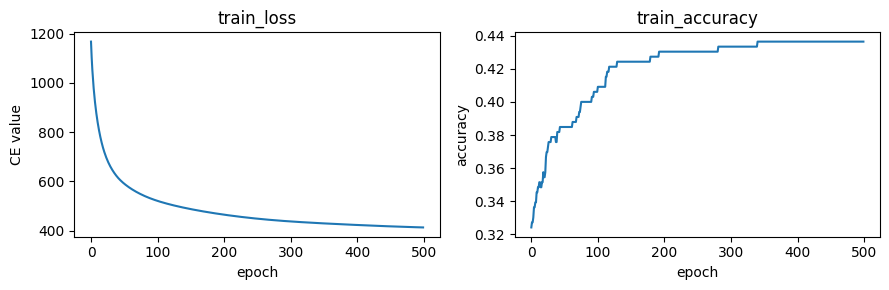

In [32]:
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(list(range(0,config['max_epochs'])),model.losses)
axs[0].set(title='train_loss',xlabel='epoch',ylabel='CE value')
axs[1].plot(list(range(0,config['max_epochs'])),model.accuracies)
axs[1].set(title='train_accuracy',xlabel='epoch',ylabel='accuracy')
fig.tight_layout()

In [35]:
from IPython.display import IFrame

wandb_report_url = 'https://api.wandb.ai/links/turkunov/f06f0bla'
IFrame(src=wandb_report_url, width=960, height=512)

### Playing around with embeddings
We're going to try extracting word embeddings as well as find closest candidates to a specific token

In [29]:
import pickle

# loading the model of version {RUN_VERSION}
RUN_VERSION = 8
model_pkl_file = f"./artifacts/w2v_v{RUN_VERSION}.pkl"  
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

def find_closest(word: str, w2i: dict, i2w: dict, model: word2vec_lite_model, k: int = 10) -> list:
    word_input = np.array([ohe(w2i[word], len(w2i))])
    candidates = model.forward(word_input).argsort()[0][::-1]
    return list(map(lambda i: i2w[i], candidates[:k]))

def generate_embedding(word: str, w2i: dict, model: word2vec_lite_model) -> np.ndarray:
    word_input = np.array([ohe(w2i[word], len(w2i))])
    _ = model.forward(word_input)
    return model.cache['f']

In [34]:
token_examples = ['mathematical', 'intelligence']
for token in token_examples:
    print(find_closest(token, w2i, i2w, model))

['based', 'a', 'model', 'data', 'build', 'in', 'known', 'mathematical', 'machine', 'used']
['machine', 'artificial', 'learning', 'improve', 'experience', 'automatically', 'to', 'through', 'data', 'the']


In [44]:
def l2(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum((x-y)**2)**.5

def cos_dist(x: np.ndarray, y: np.ndarray) -> float:
    return 1 - (x*y).sum() / ((x**2).sum() * (y**2).sum()) ** .5

pairs = [('artificial','intelligence'),('artificial','machine')]
for t1, t2 in pairs:
    emb1, emb2 = generate_embedding(t1,w2i,model), generate_embedding(t2,w2i,model)
    print(f'{t1} VS {t2} :: {cos_dist(emb1, emb2)}')

artificial VS intelligence :: 0.9878555662232731
artificial VS machine :: 1.2825832023934158


### Placing everything inside `solution.py`

In [ ]:
from solution import train

word2vec_dict, m = train(clean_and_tokenize(text,only_clean=True))

c:\Users\turku\miniconda3\envs\intense\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 61%|██████    | 304/500 [00:00<00:00, 1256.21it/s, epoch=304, loss=708]


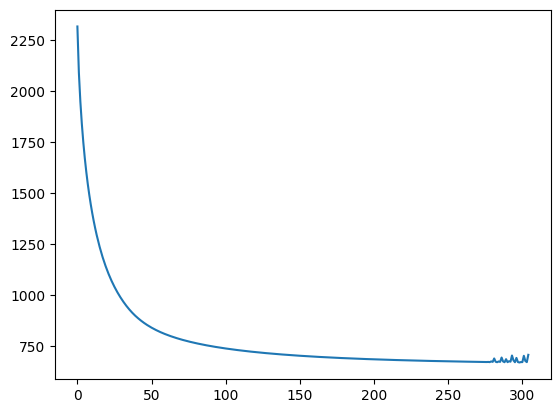

In [3]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(m.losses))),m.losses)